# Simpsons IMDb Rating Regression

Tyler Oldham

5/14/23

Use Simpsons episode data to predict the IMDb episode rating.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_raw_char = pd.read_csv('data/simpsons_characters.csv')
df_raw_loc = pd.read_csv('data/simpsons_locations.csv')
df_raw_script = pd.read_csv('data/simpsons_script_lines.csv', low_memory=False)
df_raw_eps = pd.read_csv('data/simpsons_episodes.csv')

## Clean script lines df

In [3]:
df_raw_script = df_raw_script.merge(df_raw_loc, how='left', left_on='location_id', right_on='id')
df_raw_script = df_raw_script.drop(columns=['id_y', 'raw_location_text', 'name'])
df_raw_script.head()

,id_x,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,spoken_words,normalized_text,word_count,normalized_name
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,true,464,3.0,Miss Hoover,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31,springfield elementary school
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,true,9,3.0,Lisa Simpson,Where's Mr. Bergstrom?,wheres mr bergstrom,3,springfield elementary school
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,true,464,3.0,Miss Hoover,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22,springfield elementary school
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,true,9,3.0,Lisa Simpson,That life is worth living.,that life is worth living,5,springfield elementary school
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,true,40,3.0,Edna Krabappel-Flanders,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33,springfield elementary school


In [4]:
df_raw_script['character_id'] = pd.to_numeric(df_raw_script['character_id'], downcast='integer', errors='coerce')

In [5]:
df_raw_script = df_raw_script.merge(df_raw_char, how='left', left_on='character_id', right_on='id')
df_raw_script = df_raw_script.drop(columns=['name', 'raw_character_text', 'id'])
df_raw_script.head()

,id_x,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,spoken_words,normalized_text,word_count,normalized_name_x,normalized_name_y,gender
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,true,464.0,3.0,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31,springfield elementary school,miss hoover,f
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,true,9.0,3.0,Where's Mr. Bergstrom?,wheres mr bergstrom,3,springfield elementary school,lisa simpson,f
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,true,464.0,3.0,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22,springfield elementary school,miss hoover,f
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,true,9.0,3.0,That life is worth living.,that life is worth living,5,springfield elementary school,lisa simpson,f
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,true,40.0,3.0,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33,springfield elementary school,edna krabappel-flanders,f


In [6]:
df_script_c = df_raw_script.drop(columns=['raw_text', 'spoken_words'])
df_script_c = df_script_c.rename(columns={'id_x': 'line_id',
                                          'normalized_text': 'line_text',
                                          'normalized_name_x': 'location',
                                          'normalized_name_y': 'speaker'})
df_script_c.head()

,line_id,episode_id,number,timestamp_in_ms,speaking_line,character_id,location_id,line_text,word_count,location,speaker,gender
0,9549,32,209,848000,true,464.0,3.0,no actually it was a little of both sometimes ...,31,springfield elementary school,miss hoover,f
1,9550,32,210,856000,true,9.0,3.0,wheres mr bergstrom,3,springfield elementary school,lisa simpson,f
2,9551,32,211,856000,true,464.0,3.0,i dont know although id sure like to talk to h...,22,springfield elementary school,miss hoover,f
3,9552,32,212,864000,true,9.0,3.0,that life is worth living,5,springfield elementary school,lisa simpson,f
4,9553,32,213,864000,true,40.0,3.0,the polls will be open from now until the end ...,33,springfield elementary school,edna krabappel-flanders,f


In [7]:
import pandas as pd

# Assuming df_script_c is your DataFrame

# Create one-hot encoding for 'character' and 'location' columns
df_char = pd.get_dummies(df_script_c['speaker'])
df_loc = pd.get_dummies(df_script_c['location'])

# Concatenate the one-hot encoding DataFrames to the original DataFrame
df_script_t = pd.concat([df_script_c, df_char, df_loc], axis=1)

# Group by 'episode_id' and apply max function to get whether a character or location made an appearance in the episode
df_grouped = df_script_t.groupby('episode_id').max()

df_grouped = df_grouped.drop(columns=['line_id', 'number', 'timestamp_in_ms', 'speaking_line', 'character_id', 'location_id'])

df_grouped

/var/folders/9w/0mzmgsq57djfhz1f3p3r3pm80000gn/T/ipykernel_47275/2310091994.py:13: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  df_grouped = df_script_t.groupby('episode_id').max()


,1-year-old bart,1-year-old homer,1-year-old nelson,10 years younger homer,10 years younger marge,10-year old yokel boy,10-year-old carl,10-year-old homer,10-year-old lenny,10-year-old-girl,...,yuk-ingham palace,zeigler studio,zenith city nuclear plant,zero-g jet,zerz,zhengyici theater,zhenya house,ziff estate,zip zap and za pizza arcade,zoo entrance
episode_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_eps_c = df_raw_eps.merge(df_grouped, how='inner', left_on='id', right_index=True)
df_eps_c.head()

,id,image_url,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,...,yuk-ingham palace,zeigler studio,zenith city nuclear plant,zero-g jet,zerz,zhengyici theater,zhenya house,ziff estate,zip zap and za pizza arcade,zoo entrance
0,10,http://static-media.fxx.com/img/FX_Networks_-_...,7.4,1511.0,10,10,1990-03-25,1990,7G10,1,...,0,0,0,0,0,0,0,0,0,0
1,12,http://static-media.fxx.com/img/FX_Networks_-_...,8.3,1716.0,12,12,1990-04-29,1990,7G12,1,...,0,0,0,0,0,0,0,0,0,0
2,14,http://static-media.fxx.com/img/FX_Networks_-_...,8.2,1638.0,1,14,1990-10-11,1990,7F03,2,...,0,0,0,0,0,0,0,0,0,0
3,17,http://static-media.fxx.com/img/FX_Networks_-_...,8.1,1457.0,4,17,1990-11-01,1990,7F01,2,...,0,0,0,0,0,0,0,0,0,0
4,19,http://static-media.fxx.com/img/FX_Networks_-_...,8.0,1366.0,6,19,1990-11-15,1990,7F08,2,...,0,0,0,0,0,0,0,0,0,0


## Text Mining

In [9]:
df_script_lines_c = df_script_c.dropna(subset=['line_text'])

In [10]:
df_script_lines_c.to_csv('df_script_lines_c.csv')

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tyleroldham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

stops.update(['im', 'oh', 'well', 'dont', 'like', 'get', 'youre', 'one', 'know', 'thats', 'hey', 'right', 'go', 'got',
              'ill', 'uh', 'see', 'yeah', 'think', 'want', 'cant', 'look', 'gonna', 'okay'])

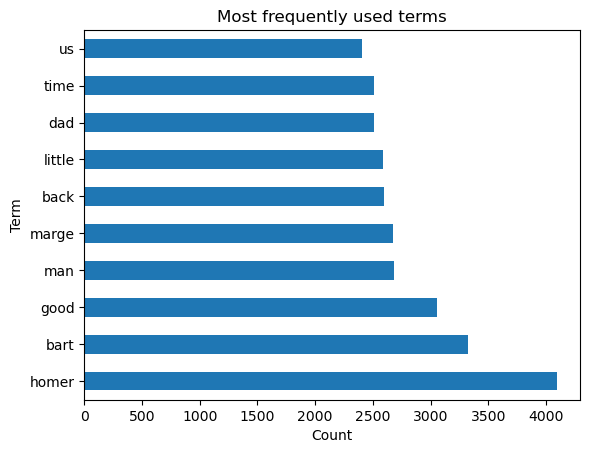

In [13]:
# The next 2 lines accomplish several steps:
# - makes everything lowercase (optional)
# - removes stop words
# - removes punctuation
# - tokenization
# Note that there is no easy way to do stemming without another library, nltk.
count_vect = CountVectorizer(lowercase=True, stop_words=stops)
sparse_counts = count_vect.fit_transform(df_script_lines_c['line_text'])

counts = sparse_counts.toarray()

terms = count_vect.get_feature_names_out()
total_counts = counts.sum(axis=0)

df_counts = pd.DataFrame({'term': terms, 'count': total_counts})

df_counts = df_counts.sort_values(by='count', ascending=False)
df_counts = df_counts.iloc[:10] # Just keep the top 10

fig, ax = plt.subplots()
df_counts.plot('term', 'count', kind='barh', ax=ax, legend=None)
plt.xlabel('Count')
plt.ylabel('Term')
plt.title('Most frequently used terms')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corp = df_script_lines_c['line_text']

tf_idf_model  = TfidfVectorizer()
tf_idf_model.fit(corp)
tf_idf_matrix = tf_idf_model.transform(corp)
tf_idf_array = tf_idf_matrix.toarray() 

In [ ]:
words_list = tf_idf_model.get_feature_names_out()
print(words_list)

df_tf_idf = pd.DataFrame(tf_idf_array, columns = words_list)
df_tf_idf